# EPA112 Programming for Data Science: Final Project
### Group 42: Angelica (6556671), Elena Deckert (6580300), Tadas Lukavicius(5525047)

TO DO: add introduction, problem statement/research question

Introduction

In recent years, the global community has recognized that social and environmental progress are deeply interconnected. Achieving sustainable development requires not only protecting the planet but also ensuring equality and inclusion for all people. The United Nations Sustainable Development Goals (SDGs) reflect this interdependence, particularly between SDG 5 (Gender Equality) and SDG 13 (Climate Action). While gender equality and environmental sustainability are often discussed separately, their relationship remains complex and not yet fully understood at a global scale.

Understanding how these two dimensions of development interact is crucial for designing effective and inclusive sustainability policies. Countries may progress differently: some might advance rapidly in environmental protection but lag behind in gender equality, while others achieve social equity without parallel ecological gains. Identifying such patterns can reveal whether global development is moving toward an integrated form of sustainability that includes both people and planet.

Problem statement:
Despite global progress toward both gender equality and environmental sustainability, disparities between countries persist, and it remains unclear whether improvements in one dimension coincide with progress in the other. Without this understanding, policymakers may overlook how social inclusion contributes to — or diverges from — environmental outcomes.

Research question:

How do countries cluster based on their performance in gender equality and environmental sustainability, and how have these clusters evolved over time?

By clustering countries using indicators of equality and sustainability, this project aims to uncover global patterns, identify outliers, and explore whether progress in gender equality aligns with progress in environmental sustainability.

# 1. Introduction

This cell installs all the necessary additional libraries.

In [48]:
!pip install pycountry -q
!pip install pycountry-convert -q
!pip install wbdata -q
!pip install ipywidgets -q
!pip install plotly -q
!pip install scikit-learn -q


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


This cell imports all the necessary libraries

In [49]:
import logging
import warnings
# Suppresses warning errors, there are too many of them there about caches from wbdata
logging.getLogger("shelved_cache.persistent_cache").setLevel(logging.ERROR)
warnings.simplefilter(action='ignore', category=FutureWarning)
import wbdata
import pandas as pd
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
import pycountry_convert
import json
from data_handler import Data_Handler
from completeness import Completeness_Ranker
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px

# 2. Datasets

## 2.1 WBData completeness analysis

First, we completed a completeness analysis on the World Bank data. This was done because the data provided by the World Bank had a lot of factors; however, a lot of them had a lot of missing data. This was done by selecting the indicators that we were interested in, namely:
- Gender Disaggregated Labour Database (GDLD)
- Country Climate and Development Report (CCDR)
- Sustainable Development Goals
- Sustainable Energy for All
- Gender Statistics 

For each of these categories, we got all the data and checked how many NaN values there were per factor. This gave us valuable insight into which data can provide the most information for our further research.

In the next cell, we provide an example of such an analysis for the _Sustainable Energy for All_ indicator. We wanted to avoid clutter in this notebook, so the complete analysis can be found in the "WBData explore" notebook.

In [50]:
se_summary, se_df = Completeness_Ranker.rank_indicators_by_completeness(35, 2000, 2025, 10)
print(se_summary.head(15))

Found 11 indicators in source 35
Fetching data for all indicators...


Fetching indicators: 100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.17it/s]


Retrieved 39126 data points


Calculating completeness: 100%|███████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 458.64it/s]

                    Indicator Code  \
1    1.1_TOTAL.FINAL.ENERGY.CONSUM   
6               3.1_RE.CONSUMPTION   
8     4.1.2_REN.ELECTRICITY.OUTPUT   
9      4.1_SHARE.RE.IN.ELECTRICITY   
0       1.1_ACCESS.ELECTRICITY.TOT   
3     1.3_ACCESS.ELECTRICITY.URBAN   
7   4.1.1_TOTAL.ELECTRICITY.OUTPUT   
5       2.1_SHARE.TOTAL.RE.IN.TFEC   
2     1.2_ACCESS.ELECTRICITY.RURAL   
4               2.1_ACCESS.CFT.TOT   
10    6.1_PRIMARY.ENERGY.INTENSITY   

                                       Indicator Name  Completeness  \
1               Total final energy consumption (TFEC)      0.610782   
6                   Renewable energy consumption (TJ)      0.610782   
8           Renewable energy electricity output (GWh)      0.610618   
9   Renewable electricity (% in total electricity ...      0.610618   
0       Access to electricity (% of total population)      0.604043   
3       Access to electricity (% of urban population)      0.604043   
7                      Total electricity outpu

## 2.2 Pulling the data

Next, we chose data depending on their completeness and interest in our research.

From the World Bank data, we chose:
- Renewable energy share: Renewable electricity share of total electricity output (%): Electricity generated by power plants using renewable resources as a share of total electricity output.
- Basic drinking water:	The percentage of people using at least basic water services. This indicator encompasses both people using basic water services as well as those using safely managed water services.

From the Environmental Performance Index by Yale, we chose:
- Species protection index: measures how well a country's terrestrial protected areas overlap with the ranges of its vertebrate, invertebrate, and plant species.
- Air Pollution SO2 trend: measures exposure to ground-level sulfur dioxide using a country’s ambient ground-level concentration.
- Ambient PM2.5 from human resources: measures the exposure to fine particulate matter pollution from anthropogenic sources, such as the burning of fossil fuels, which are easier to influence through policy than natural sources.
- Marine Habitat Protection: measures the percentage of the area of important marine and coastal habitats under official protection within a country’s Exclusive Economic Zone(s).

From the Human Development Index by the United Nations, we chose:
- GII: composite metric of gender inequality using three dimensions: reproductive health, empowerment and the labour market. A low GII value indicates low inequality between women and men, and vice versa.
- Shares of seats in the parliament, female: percentage of parliamentary seats held by women.
- Labour force participation, female: percentage of women who are working or actively seeking work.
- Population with secondary education, female: percentage of women who have completed secondary education.

Note: We had to download the Renewable energy consumption share data separately because the API from the World Bank had incomplete data. The data retrieved via the API had no data after 2015; thus, we downloaded the data separately and imported it.

In the next cell, we get the said data from according sources.

In [51]:
# Initialise data indicators and relative names for the columns in the data
indicators_wb = { "SH.H2O.BASW.ZS" :  "Basic drinking water"}
indicators_yale = { "SPI" : "Species protection index",
              "SDA" : "Air Polution SO2 trend",
              "HPE" : "Ambient PM2.5 from human resources", 
              "MHP" : "Marine Habitat Protection"}
indicators_hdi = {"gii" : "GII",
                 "pr_f" : "Shares of seats in the parliament, female",
                 "lfpr_f" : "Labour force participation, female",
                 "se_f" : "Population with secondary education, female"}

# Get world bank data
wbdata = Data_Handler.get_data_WB(
    indicators_wb, 
    countries="all", 
    start_year=1990, 
    end_year=2025
 )
# Get HDI data
hdi_data = Data_Handler.get_data_HDI(
    filepath="HDR25_Composite_indices_complete_time_series.csv",
    indicators=indicators_hdi,
    countries=None,
    start_year=1990,
    end_year=2024
)
# Get EPI data
epi_data = Data_Handler.get_data_EPI(
    indicators=indicators_yale,
    countries=None,
    start_year=1990,
    end_year=2024
)

re_data = Data_Handler.get_renewable_energy_data(
    file_path="API_EG.FEC.RNEW.ZS_DS2_en_csv_v2_130800.csv",
    start_year=1990,
    end_year=2024
)

In the next cell, we merge all data into one dataframe.

In [52]:
# Rename columns for consistency
wbdata.rename(columns={'Country': 'country', 'Year': 'year'}, inplace=True)

# Pivot the HDI dataset so that each metric_name becomes a column
hdi_data_pivot = hdi_data.pivot_table(
    index=['country', 'year'],   
    columns='metric_name',       
    values='value'               
).reset_index()                  

# Pivot the EPI dataset 
epi_data_pivot = epi_data.pivot_table(
    index=['country', 'year'],
    columns='variable_name',     # Each variable_name becomes a column
    values='value'
).reset_index()

# Merge all three datasets on 'country' and 'year'
data = (
    wbdata
    .merge(hdi_data_pivot, on=['country', 'year'], how='outer')
    .merge(epi_data_pivot, on=['country', 'year'], how='outer')
    .merge(re_data, on=['country', 'year'], how='outer')
)

## 2.3 Data preprocessing

In this section, we complete all necessary data preprocessing.

To get a standardised list of country names, we will be using pycountry. This library contains an ISO list of country names. Additionally, some "countries' are actually regions (e.g. Eurozone, the world, etc), so we skipped those as we are interested in the dynamics between different countries. We used a mapping of countries that were picked manually, because different datasets had different names for countries (e.g. "Czezh Republic" and "Czechia"), which was saved in a JSON format in the file country_names_mapping.json. This approach was done in order to reduce clutter in the notebook.

In [53]:
# Create a set of official country names from the pycountry library
pycountry_names = set([c.name for c in pycountry.countries])
country_map = {}
for name in data['country'].unique():
    if name in pycountry_names:
        country_map[name] = name

# Load a mapping file that contains manual corrections for country names not recognised by pycountry
with open("country_names_mapping.json", "r", encoding="utf-8") as f:
    map_update = json.load(f)

# Update the country_map with custom name mappings
country_map.update(map_update)
data['country'] = data['country'].map(country_map)

# Drop rows where 'country' is NaN
data = data.dropna(subset=['country'])

# Group by country and year to ensure unique records per pair
# If there are duplicates, `.first()` keeps the first occurrence
data = data.groupby(['country', 'year'], as_index=False).first()


In the next cell, we make a continent variable, which will later help us identify patterns between different continents.

In [54]:
def get_continent(country_name):
    try:
        # Try to find the country by exact name first
        country = pycountry.countries.get(name=country_name)
        
        # If not found, try fuzzy search
        if country is None:
            country = pycountry.countries.search_fuzzy(country_name)[0]
        
        # Get ISO Alpha-2 code
        country_code = country.alpha_2
        
        # Convert to continent code and name
        continent_code = pycountry_convert.country_alpha2_to_continent_code(country_code)
        continent_name = pycountry_convert.convert_continent_code_to_continent_name(continent_code)
        
        return continent_name

    except Exception:
        return 'Unknown'

# Apply to your DataFrame
data['continent'] = data['country'].apply(get_continent)

After the previous cell, due to the mismatch between the names in the pycountry list and the dataset, a few countries were not identified. For these countries, we assigned the continent manually. This was done in the next two cells.

In [55]:
unknown_continent_countries = data[
    (data['continent'].isna()) | (data['continent'] == 'Unknown')
][['country']].drop_duplicates()

print(unknown_continent_countries)

                               country
1709  Democratic Republic Of The Congo
1884                        East Timor
3979                  Macao SAR, China
6108         Sint Maarten (Dutch part)
7288                    Western Sahara


In [56]:
data.loc[data["country"] == "Democratic Republic Of The Congo", "continent"] = "Africa"
data.loc[data["country"] == "Macao SAR, China", "continent"] = "Asia"
data.loc[data["country"] == "Sint Maarten (Dutch part)", "continent"] = "North America"
data.loc[data["country"] == "Western Sahara", "continent"] = "Africa"
data.loc[data["country"] == "East Timor", "continent"] = "Asia"

Later, we plotted the missing values by year in a bar graph.

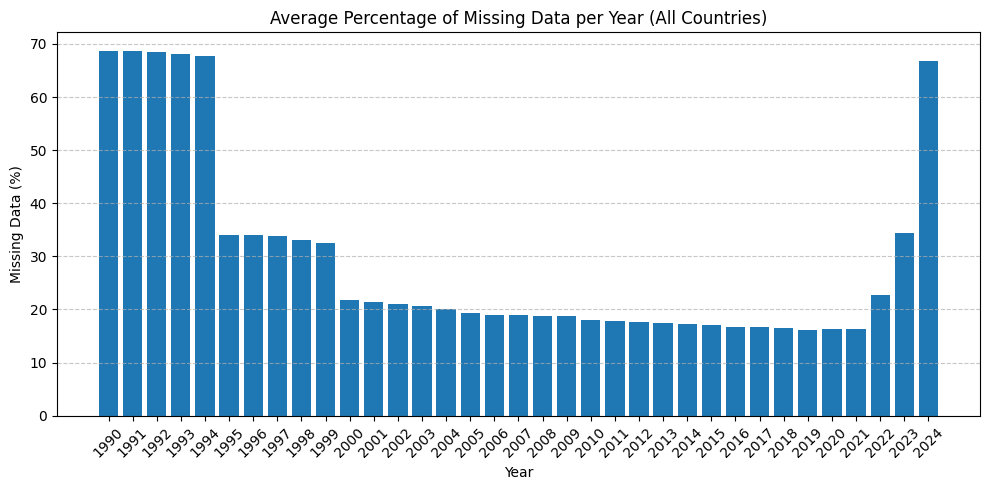

In [57]:
# Exclude trivial columns
cols_to_check = [c for c in data.columns if c not in ['year', 'country', 'continent']]

# Percentage of NaN values per year (average across all countries and columns)
nan_by_year = data.groupby('year')[cols_to_check].apply(lambda x: x.isna().mean().mean() * 100)

# Plot NaN values
plt.figure(figsize=(10,5))
plt.bar(nan_by_year.index.astype(str), nan_by_year.values)
plt.title('Average Percentage of Missing Data per Year (All Countries)')
plt.xlabel('Year')
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

As we can see from the bar graph, a lot of the missing data is before 2000 and after 2022, thus, we have decided to exclude this data from our dataset.

In [58]:
data = data[(data['year'] >= 2000) & (data['year'] <= 2022)]

Next, we plot countries and the percentage of missing values per country.

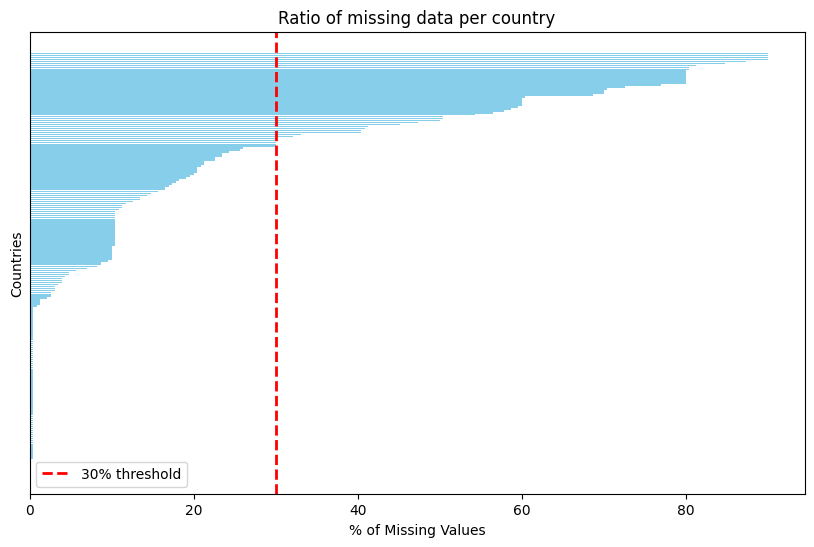

In [59]:
# Get NaN values by country
nan_by_country = data.groupby('country')[cols_to_check].apply(lambda x: x.isna().mean().mean() * 100)
nan_by_country = nan_by_country.sort_values(ascending=False)

# Plot NaN values
plt.figure(figsize=(10,6))
plt.barh(range(len(nan_by_country)), nan_by_country.values, color='skyblue')  # use range for no labels
plt.axvline(x=30, color='red', linestyle='--', linewidth=2, label='30% threshold')  # red line at 30%
plt.xlabel('% of Missing Values')
plt.ylabel("Countries")
plt.title('Ratio of missing data per country')
plt.yticks([])  # remove y-axis labels
plt.legend()
plt.gca().invert_yaxis()  # largest on top
plt.show()


From the graph, we can see that a lot of the countries have a majority of their data missing. We have decided to exclude countries that have more than 70 per cent data missing, which is indicated by the red line in the graph.

In [60]:
def nan_mean_excluding_marine(x):
    # Exclude 'Marine Habitat Protection' if all NaN for this country
    if 'Marine Habitat Protection' in x.columns and x['Marine Habitat Protection'].isna().all():
        return x.drop(columns=['Marine Habitat Protection']).isna().mean().mean() * 100
    else:
        return x.isna().mean().mean() * 100
before_excl = len(data["country"].unique())
# Compute missing-data percentage per country
country_nan_percent = data.groupby('country')[cols_to_check].apply(nan_mean_excluding_marine)

# Keep only countries with <= 30% missing data
valid_countries = country_nan_percent[country_nan_percent <= 30].index

# Filter the main DataFrame
data = data[data['country'].isin(valid_countries)]
after_excl = len(data["country"].unique())

print(f"{before_excl - after_excl} countries removed from the data.")

43 countries removed from the data.


Now, we want to inspect the trends of missing data between different factors in our dataset.

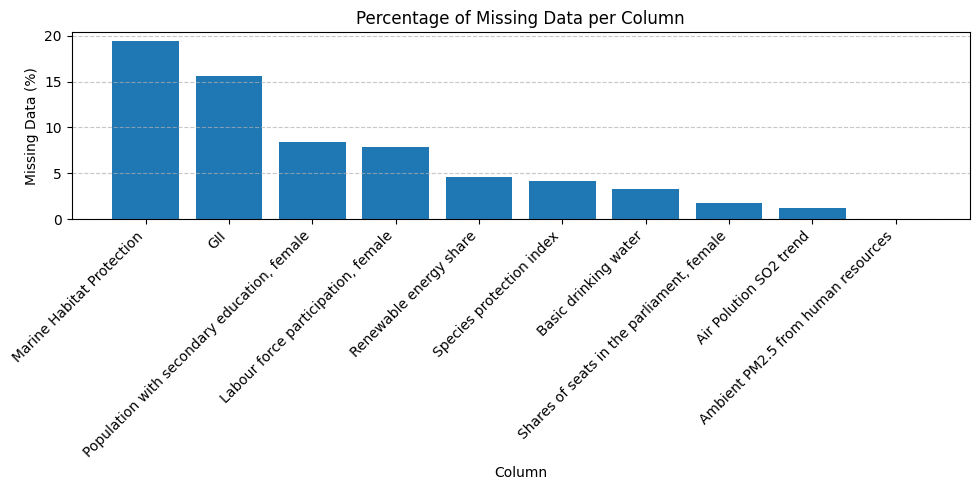


Missing data percentage per column (sorted):
Marine Habitat Protection                      19.411765
GII                                            15.652174
Population with secondary education, female     8.363171
Labour force participation, female              7.877238
Renewable energy share                          4.578005
Species protection index                        4.117647
Basic drinking water                            3.324808
Shares of seats in the parliament, female       1.790281
Air Polution SO2 trend                          1.176471
Ambient PM2.5 from human resources              0.000000
dtype: float64


In [61]:
# Get NaN values per column
nan_per_column = data[cols_to_check].isna().mean() * 100
nan_per_column_sorted = nan_per_column.sort_values(ascending=False)

# Plot NaN values
plt.figure(figsize=(10,5))
plt.bar(nan_per_column_sorted.index, nan_per_column_sorted.values)
plt.title(f'Percentage of Missing Data per Column')
plt.xlabel('Column')
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nMissing data percentage per column (sorted):")
print(nan_per_column_sorted)

The highest factor in missing data is for Marine Habitat Protection. That is because there are landlocked countries, for example, Slovakia, which do not have access to seas or Oceans, and thus cannot have any marine habitat protection.

## 2.4 Uniformize data

Next, we look at the minimum and maximum values each column can obtain. All factors except for GII are measured from 0 to 100. We have decided to multiply the GII by a factor of 100, as this will later help us visualise the results.

In [62]:
# Print min and max values of each column
min_max = data.agg(['min', 'max']).transpose().reset_index()
min_max.columns = ['Column', 'Min', 'Max']
print(min_max)

# Multiply GII by a 100
data['GII'] = data['GII'] * 100

                                         Column          Min            Max
0                                       country  Afghanistan       Zimbabwe
1                                          year         2000           2022
2                          Basic drinking water    18.682303          100.0
3                                           GII        0.004           0.84
4            Labour force participation, female         5.72           94.4
5   Population with secondary education, female     1.761277          100.0
6     Shares of seats in the parliament, female          0.0       57.54717
7                        Air Polution SO2 trend          0.0          100.0
8            Ambient PM2.5 from human resources          0.0          100.0
9                     Marine Habitat Protection          0.0          100.0
10                     Species protection index          0.0          100.0
11                       Renewable energy share          0.0           96.0
12          

## 2.5 Basic Stats

Next we tried to get a general overview of the numeric value columns

In [63]:
data.describe()

,year,Basic drinking water,GII,"Labour force participation, female","Population with secondary education, female","Shares of seats in the parliament, female",Air Polution SO2 trend,Ambient PM2.5 from human resources,Marine Habitat Protection,Species protection index,Renewable energy share
count,3910.000000,3780.000000,3298.000000,3602.000000,3583.000000,3840.000000,3864.000000,3910.000000,3151.000000,3749.000000,3731.000000
mean,2011.000000,85.716722,37.075591,50.124606,55.265431,18.876819,66.454451,43.563964,22.111933,36.525020,32.332485
std,6.634098,17.610250,19.620179,15.601038,30.642818,11.432121,32.417434,30.444452,22.481686,27.474321,29.029545
min,2000.000000,18.682303,0.400000,5.720000,1.761277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005.000000,77.797856,19.300000,41.802500,27.016138,10.000000,41.800000,19.700000,3.700000,13.000000,7.300000
50%,2011.000000,93.756772,38.100000,51.600000,56.299999,17.449664,70.850000,37.100000,16.000000,32.200000,23.900000
75%,2017.000000,99.124099,53.100000,59.207500,85.219448,25.903614,100.000000,64.850000,35.400000,57.400000,52.000000
max,2022.000000,100.000000,84.000000,94.400000,100.000000,57.547170,100.000000,100.000000,100.000000,100.000000,96.000000


## 2.6 Missing values
Next, we examine the number of missing values in the dataset to determine an appropriate method for handling them. This step is important because missing data can negatively impact analyses, particularly in machine learning applications that can often not deal with missing values.

In [64]:
data.isna().sum()

country                                          0
year                                             0
Basic drinking water                           130
GII                                            612
Labour force participation, female             308
Population with secondary education, female    327
Shares of seats in the parliament, female       70
Air Polution SO2 trend                          46
Ambient PM2.5 from human resources               0
Marine Habitat Protection                      759
Species protection index                       161
Renewable energy share                         179
continent                                        0
dtype: int64

We can see that there is still a significant number of missing values. For 'Marine Habitat Protection', we decided to check if the values are missing for a country entirely. If that is the case, we decided to replace the values with 100 as we assume it is a landlocked country and it therefore does not have any entries. The reason why we chose 100 for landlocked countries is that the metric measures how much of the water habitat is protected, thus, if a country has no land area, we assume that all of it the area is protected. In the other columns, we interpolated the values linearly for each country based on the existing years.

In [65]:
# fill landlock with 100 
def fill_marine_habitat(group):
    if group['Marine Habitat Protection'].isna().all():
        group['Marine Habitat Protection'] = 100
    return group

data = data.groupby('country', group_keys=False).apply(fill_marine_habitat)

# interpolate missing values per country based on previous and following years
data = (
    data.sort_values(['country', 'year'])
        .groupby('country', group_keys=False)
        .apply(lambda g: g.interpolate(method='linear', limit_direction='both'))
)

data.isna().sum()

country                                          0
year                                             0
Basic drinking water                            46
GII                                            207
Labour force participation, female              69
Population with secondary education, female     69
Shares of seats in the parliament, female        0
Air Polution SO2 trend                          46
Ambient PM2.5 from human resources               0
Marine Habitat Protection                        0
Species protection index                       161
Renewable energy share                          46
continent                                        0
dtype: int64

After doing this, we still have missing values. This can be caused when countries are completely missing entries for a full column and therfore it is not possible to interpolate. Let's check this assumption:

In [66]:
cols = [
    'Renewable energy share',
    'Basic drinking water',
    'GII',
    'Labour force participation, female',
    'Population with secondary education, female',
    'Air Polution SO2 trend',
    'Species protection index'
]

# Check per country if all values in a column are missing 
missing_summary = (
    data.groupby('country')[cols]
        .apply(lambda g: g.isna().all())
)

print("Number of countries entirely missing per indicator:")
print(missing_summary.sum())

Number of countries entirely missing per indicator:
Renewable energy share                         2
Basic drinking water                           2
GII                                            9
Labour force participation, female             3
Population with secondary education, female    3
Air Polution SO2 trend                         2
Species protection index                       7
dtype: int64


In [67]:
for col in cols:
    missing_countries = missing_summary.index[missing_summary[col]]
    if len(missing_countries) > 0:
        print(f"\n{col} — {len(missing_countries)} countries missing:")
        print(list(missing_countries))
    else:
        print(f"\n{col} — no countries fully missing.")


Renewable energy share — 2 countries missing:
["Lao People's Democratic Republic", 'Saint Lucia']

Basic drinking water — 2 countries missing:
["Lao People's Democratic Republic", 'Saint Lucia']

GII — 9 countries missing:
['Central African Republic', 'Dominica', 'Kiribati', 'Marshall Islands', 'Palau', 'Seychelles', 'Turkmenistan', 'Tuvalu', 'Ukraine']

Labour force participation, female — 3 countries missing:
['Central African Republic', 'Dominica', 'Turkmenistan']

Population with secondary education, female — 3 countries missing:
['Kiribati', 'Seychelles', 'Ukraine']

Air Polution SO2 trend — 2 countries missing:
['Syrian Arab Republic', 'Tuvalu']

Species protection index — 7 countries missing:
['Kiribati', 'Libya', 'Maldives', 'Palau', 'Syrian Arab Republic', 'Tuvalu', 'Yemen']


Our assumption is correct. In these cases, we decided to fill the values with the mean of the corresponding continent for each year. This is a limitation because it is a strong assumption to fill the values simply based on the continent mean, as there can be big differences within continents that we are not accounting for. Based on the countries that are affected, we decided that this is still the most suitable approach, but we have to keep it in mind for further analysis, as it could be a cause for unexpected values.

In [68]:
# fill values with  mean of the according continent for each year
for col in cols:
    data[col] = data.groupby(['continent', 'year'])[col].transform(
        lambda x: x.fillna(x.mean())
    )

In [69]:
data.isna().sum()

country                                        0
year                                           0
Basic drinking water                           0
GII                                            0
Labour force participation, female             0
Population with secondary education, female    0
Shares of seats in the parliament, female      0
Air Polution SO2 trend                         0
Ambient PM2.5 from human resources             0
Marine Habitat Protection                      0
Species protection index                       0
Renewable energy share                         0
continent                                      0
dtype: int64

Now we have a complete dataset.

# 3. Data Exploration
## 3.1 Distribution and Outliers
We start by getting a general idea of the distribution of values by plotting a histogram for each feature. The aim of this step is to highlight extremes and general tendencies to get a fundamental understanding of the data we are dealing with. First, we are going to plot the distributions of countries for all factors in 2022.

array([[<Axes: title={'center': 'Basic drinking water'}>,
        <Axes: title={'center': 'GII'}>,
        <Axes: title={'center': 'Labour force participation, female'}>],
       [<Axes: title={'center': 'Population with secondary education, female'}>,
        <Axes: title={'center': 'Shares of seats in the parliament, female'}>,
        <Axes: title={'center': 'Air Polution SO2 trend'}>],
       [<Axes: title={'center': 'Ambient PM2.5 from human resources'}>,
        <Axes: title={'center': 'Marine Habitat Protection'}>,
        <Axes: title={'center': 'Species protection index'}>],
       [<Axes: title={'center': 'Renewable energy share'}>, <Axes: >,
        <Axes: >]], dtype=object)

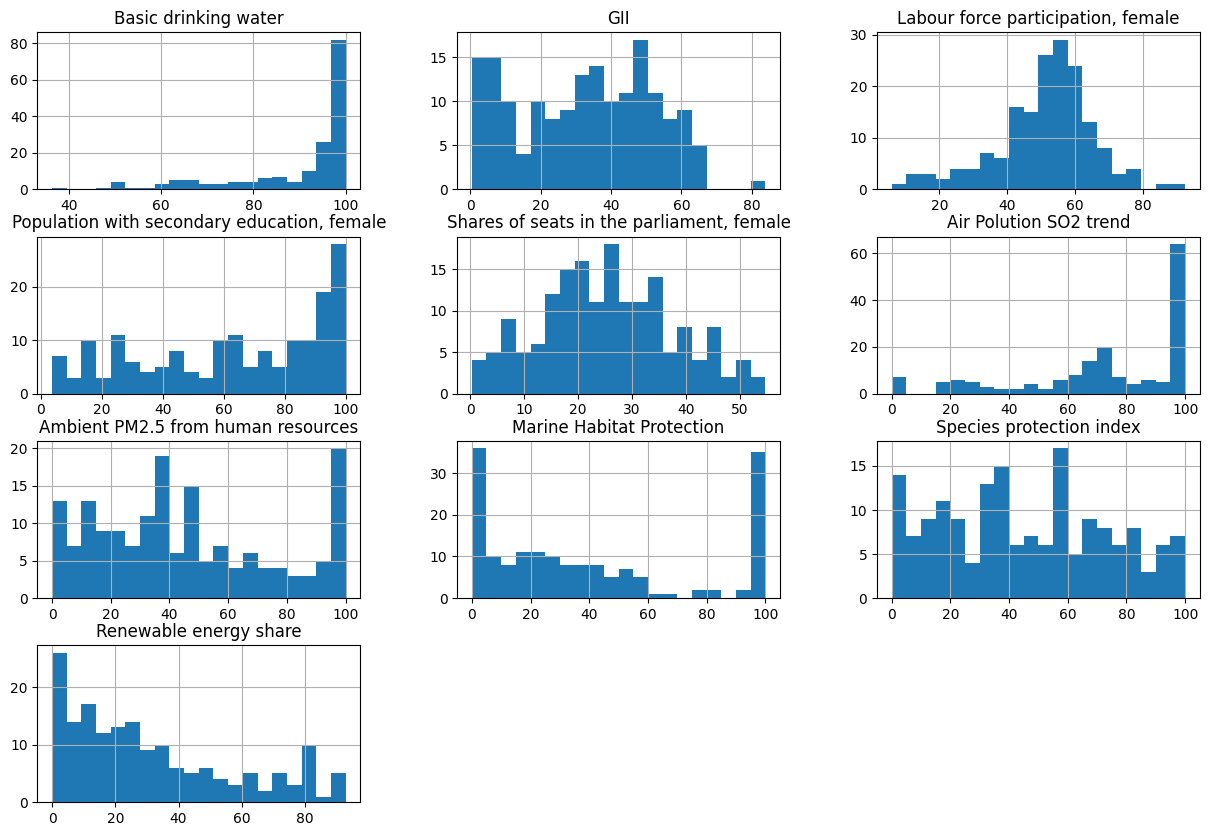

In [70]:
# Filter the data for year 2022
data_2022 = data[data['year'] == 2022]

# Select numeric columns except 'year'
numeric_cols = [col for col in data_2022.select_dtypes(include=np.number).columns if col not in ['year']]

# Plot histograms for 2022 data
data_2022[numeric_cols].hist(figsize=(15, 10), bins=20)

**Basic Drinking Water:** The distribution is right-skewed. It has a lot of entries at 100 and then quickly decreases in occurrences of lower values. This indicates that most countries already have nearly universal access to basic drinking water (values close to 100), but a smaller group has very low access. One can derive a global inequality in water access. While many countries plateaued near full coverage, a few are still progressing, and a minority lags far behind.

**GII:** The distribution suggests a bimodal distribution. There is an indication of two clusters, one group of countries with low inequality (developed nations) and another with medium inequality (developing nations). The higher values are barely reached. One could interpret it as a development divide between groups of countries. Additionally, there is a small bump at the 80 mark, indicating countries that have a very low GII.

**Labour force participation, female:** Most countries have moderate female participation rates (40-65%), with fewer countries having very low or very high rates (bell curve). Participation tends to centre around a global average, possibly constrained by cultural and traditional norms.

**Population with secondary education, female:** Education access is fairly spread but concentrated at the upper and a bit less at the lower end. Global educational attainment for women is improving, but not universally. There is a great difference in access, while a group of countries with very low female secondary education and another with very high attainment, there are a lot of countries in transition between these extremes.

**Share of seats in parliament, female:** Most countries have a rather low to moderate representation (10-35%), with fewer countries having very high representation. Progress toward political representation is uneven — only a few countries achieve gender parity. Generally, the values do not go towards 100% because one would expect 50% as being the desired ratio.

**Air polution SO2 trend:** The peaks suggest a split. While a lot of countries still have very high pollution trends, fewer countries have moderate to very little pollution. This indicates the difference in environmental policies. Developed countries have been aiming to reduce SO₂ emissions drastically, while other countries have not at all.

**Ambient PM2.5 from human resources:** The left skew means most countries have relatively low to moderate PM2.5 exposure (0–40), while a smaller group of countries have very high values near 100. This distribution indicates global inequality in air quality. Many nations enjoy relatively clean air, but a minority face severe pollution levels.

**Marine Habitat Protection:** Most coastal countries protect very little of their marine area, while landlocked countries are artificially at 100 (no marine area to protect). Marine conservation remains very limited globally.

**Species protection index:** Many countries do very little species protection, while only a few perform very well. Might reflect differences in biodiversity policy, data reporting, or resource availability.

**Renewable energy share:** Left-skewed distribution with a lot of countries with low renewable energy use. There is a cluster with high renewable adoption, indicating a strong divide between industrialised fossil economies and renewable leaders.

## 3.2 Continent & Country Analysis

We decided we want to do some analysis based on continents instead of individual countries. Therefore, we verified that every continent is adequately represented, considering the number of countries on each continent in relation to the total number of countries in our dataset. The plot shows that Africa, Asia, Europe, and South America are moderately or well represented, whereas North America and Oceania are not. That is due to the fact that there are a lot of islands which are not well represented in the datasets we used for this project.
cite: https://worldpopulationreview.com/country-rankings/official-names-of-countries

<Axes: title={'center': 'Representation ratio by continent'}, xlabel='continent', ylabel='Ratio'>

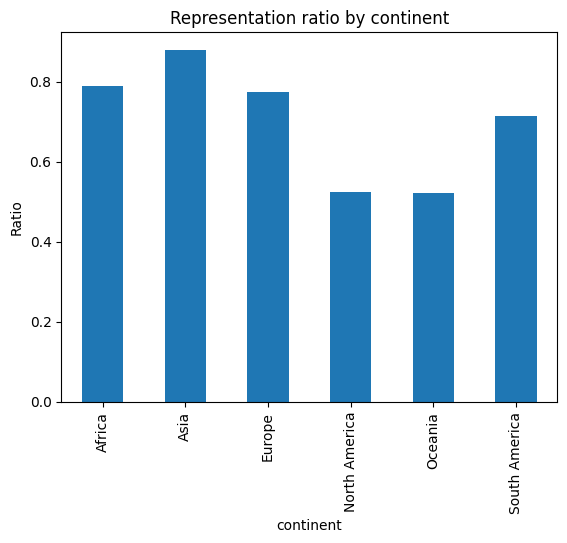

In [72]:
# number of countries per continent
countries_total = {
    'Africa': 57,
    'Asia': 50,
    'Europe': 49,
    'North America': 40,
    'Oceania': 23,
    'South America': 14
}

counts = data.groupby('continent')['country'].nunique()
ratios = counts / pd.Series(countries_total)

ratios.plot(kind='bar', title='Representation ratio by continent', ylabel='Ratio')

Next, we aimed to examine differences in the features across continents. To identify differences in spread or central tendency we used boxplots for each feature by continent. Later in our analysis the goal is to find clusters in countries but as a primary step it is interesting to see if we can already identify patterns within continents. In this step we aim to anayse the following questions:

How do continents differ in median values, variability, and outliers?
Which features show large regional disparities?

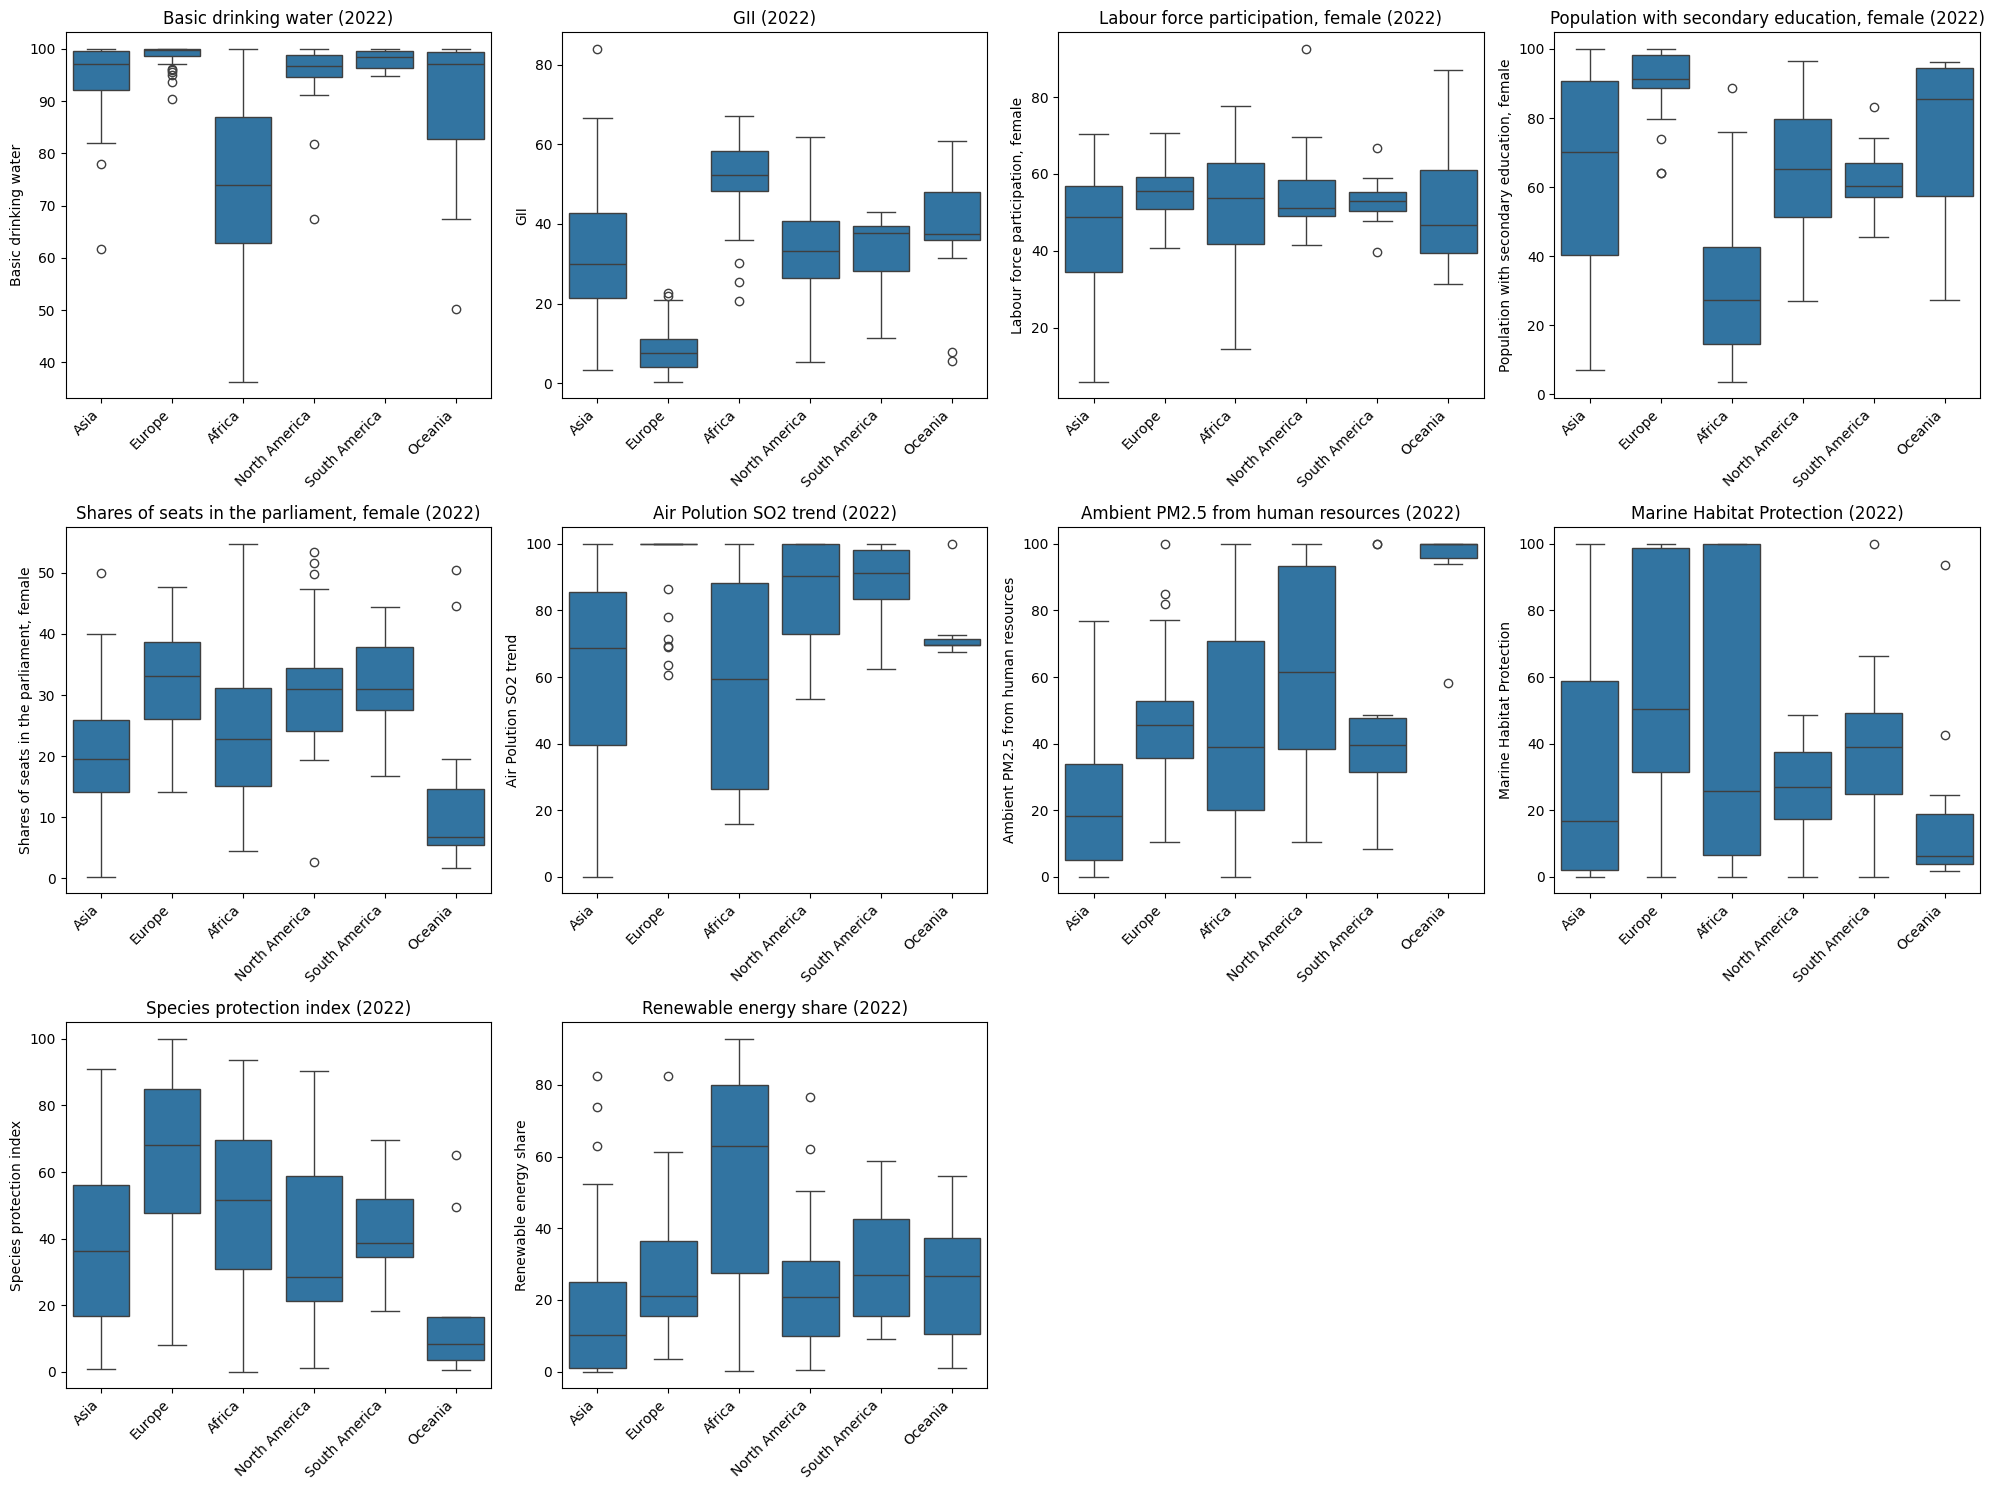

In [75]:
# Filter for only year 2022
data_2022 = data[data['year'] == 2022]

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(data=data_2022, x='continent', y=col, ax=axes[i])
    axes[i].set_title(f"{col} (2022)")
    axes[i].set_xlabel("")
    axes[i].tick_params(axis='x', rotation=45)
    for tick in axes[i].get_xticklabels():
        tick.set_ha('right')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


**Basic drinking water:** Most continents are clustered near the top, showing high coverage. Africa stands out because its median is lower and whiskers are longer, indicating a greater variability in access. Asia has many low outliers, showing countries with much worse coverage than the median. Oceania and North America show a gap and then a line of outliers, indicating most countries have very high access, but a few lag far behind. Drinking water coverage is generally high, but Africa shows the largest disparities.

**GII:** Most continents are centred, with Europe positioned lower (less inequality) and Africa slightly higher (more inequality). Asia and North America have long whiskers spanning the axis, reflecting countries with very low or very high inequality. Gender inequality shows regional variability, with extremes present in Africa, Asia, North America and Oceania.

**Labour force participation, female:** Boxes are very central for most continents, indicating similar medians. Europe and South America have short whiskers. Africa, Oceania and Asia show long whiskers, suggesting more variability in female labour participation, so wider disparities.

**Population with secondary education, female:** Africa has a low median with a long upper whisker and outliers, reflecting some countries achieving high education while most remain low. Europe has a high median with a long lower whisker and a couple of outliers, showing some countries slightly behind the majority. South America has a very narrow box, indicating consistent moderate education. Asia and Oceania have high means, although the whiskers down are long, showing that, while generally these continents do well on education, there are still a few countries which are struggling to achieve good education for women.

**Shares of seats in the parliament, female:** Median values are similar across continents. Oceania has a lower median but a couple of upward outliers, indicating high female political representation. While general representation is similar, some continents have exceptional outliers. Long whiskers upward for Africa indicate that in some countries, there are more women in the parliament than men.
<img src="78c74f63ad9b068c0b53ca53324d40aed74f92f96368efaf74f967099e4776a8_1.jpg" width="400">

**Air polution SO2 trend:** Americas have very high values. Europe’s box is furthest at the top, with outliers extending downward, and very little visible variation in the median. Oceania is intermediate, with very little variance, whereas Asian and Africa have very high variance.

**Ambient PM2.5 from human resources:** Europe and South America in the lower half with moderate whiskers. Asia is slightly lower with a long upward whisker, Africa and North America are higher with long boxes, showing variability. Oceania is all at the top with a line of outliers down, reflecting extreme values.

**Marine habitat protection:** Europe and Africa have long boxes from top to mid, likely influenced by landlocked countries coded as 100, skewing the distribution. Other continents are generally lower, with high variability. The data is distorted by landlocked countries, but in general, marine protection shows high variability.

**Species protection index:** Most continents are in the lower half, indicating generally low species protection. Oceania is slightly lower, with many upward outliers (some countries doing much better). Species protection is low globally, but some outliers indicate success in isolated countries.

**Renewable energy share:** Most continents rank in the lower half of renewable-energy share, showing relatively slow uptake. However, Africa is an exception. While the overall share of renewable energy use remains low, several African countries, due to the hydropower, solar and wind deployments, have high shares of renewables in their electricity.

cite: https://www.irena.org/How-we-work/Africa

**Main findings:**
Africa consistently shows lower medians and higher variability in access to basic services (drinking water, secondary education, female labour participation), while Europe generally shows higher medians and lower variability. This pattern shows a global development disparity, with Africa facing challenges across several human development indicators, while Europe generally performs strongly, and other continents display mixed outcomes.

Features like renewable energy share, species protection, and marine habitat protection are generally low across continents, with high variability and some outliers. Africa’s high renewable energy values are unusual but can be explained by specific countries with high hydro or solar adoption which can not be taken as a representation of the continent as a whole.

Overall, human development indicators (water access, education, female participation) show clear continental patterns, while environmental and governance indicators are more heterogeneous.

Finally for this section we decided it is also useful to get insight on the individual countries, not just the continent level. Also the aspect of development over time has not really been explored yet. since this adds a lot of dimensions to the plot we created a interactive plot that is aimed at just getting a general idea of the data over time. We visaulized the GII and Renewable Energy Share as we consider these as two main indicators for our analysis.

In this step we can answer the questions:
How do features change over time regionally?
Are there regional clusters of high or low values?

In [27]:
# TO DO: adjust formatting??
def plot_interactive_map (feature):
    fig = px.choropleth(
        data_frame=data,
        locations="country",
        locationmode="country names",
        color=feature,
        hover_name="country",
        animation_frame="year",
        color_continuous_scale="Viridis",
        title=f"{feature} over time"
    )

    # set the layout of the figure
    fig.update_layout(
        width=1200,      
        height=700,      
        coloraxis_colorbar=dict(
            title=feature,    
            thickness=25,  
            lenmode="fraction",
            len=0.8        
        ),
        title=dict(font=dict(size=20))  
    )

    fig.show()
    
plot_interactive_map("GII")
plot_interactive_map("Renewable energy share")

C:\Users\lukav\AppData\Local\Temp\ipykernel_27120\4160032366.py:3: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(


C:\Users\lukav\AppData\Local\Temp\ipykernel_27120\4160032366.py:3: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



For both indicators we see a general improvement over time. Beyond that the gegraphical location overall is an indicator for the feature value. The maps reinforce the regional disparities we saw in the boxplots.

TO DO: add more of a conclusion, point out specific countries?

TO DO: make clear distinction between what is min max colour

TO DO: maybe cite a paper for the african countries using clean energy

## 3.3 Correlation

First we explored the correlation between features with a correlation map. 
The idea was to not only simply explore correlation but also understanding if there are unwxpected correlations worth exploring.

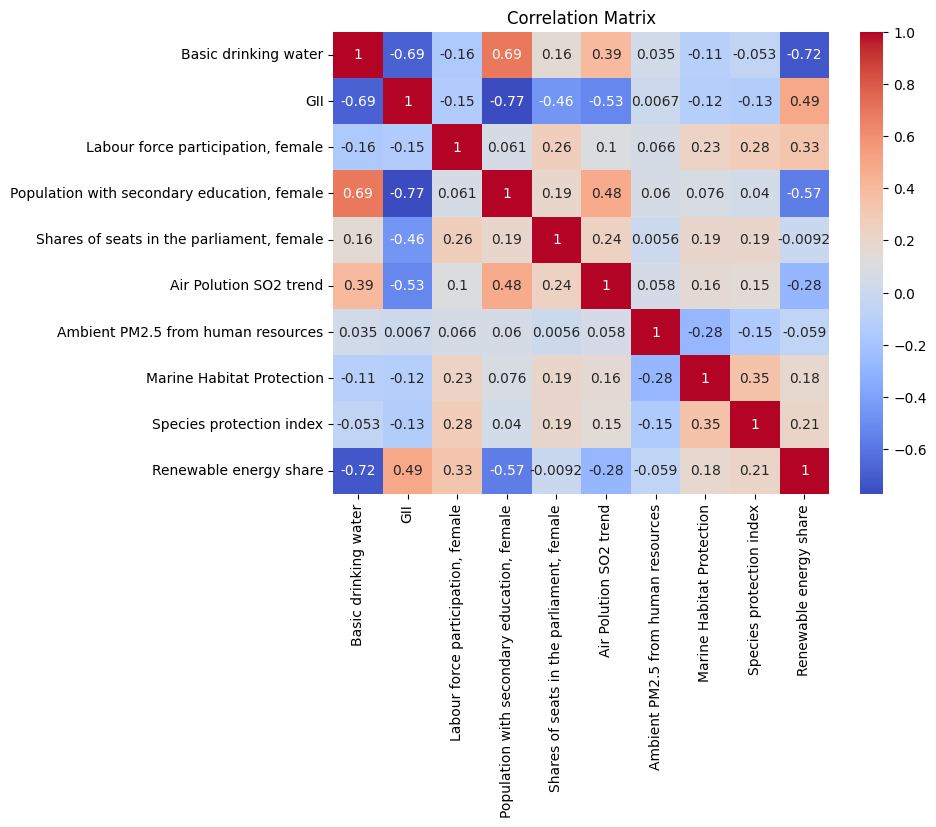

In [28]:
corr_matrix = data[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

From the correlation matrix we can see that  that the following pairs have interestingly high correlation (>0.6):
Renewable energy share - Basic drinking water
GII - Basic drinking water
Population with secondary education, female - Basic drinking water
Population with secondary education, female - GII

TO DO: add a sentence on if these correlations make sense or are rather unexpected. maybe also emohasies some low correlation pairs

In a second step we wanted to visualize the most interesting correlations in more detail. We chose to visualize them for 2002 and 2022 to see the difference in time using an interactive plot to be able to understand outliers withing the correlation patterns.
By doing this we can identify specific countries as outliers or see their development.

In [29]:
data_2002_2022 = data[data['year'].isin([2002, 2022])]

# Identify highly correlated pairs
high_corr = []
for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2 and 0.6 < abs(corr.loc[col1, col2]):
            pair = tuple(sorted([col1, col2]))
            if pair not in high_corr:
                high_corr.append(pair)
                
# loop through highly correlated pairs and create one figure per pair
for x_col, y_col in high_corr:
    fig = px.scatter(
        data_2002_2022,
        x=x_col,
        y=y_col,
        color='continent',
        facet_col='year',           # side-by-side plots for 2002 & 2022
        hover_name='country',       # show country on hover
        category_orders={'year':[2002, 2022]}, 
        title=f'{x_col} vs {y_col} (2002 vs 2022)'
    )
    
    fig.update_layout(
        width=1200,
        height=500,
        legend_title_text='Continent'
    )
    
    fig.show()


NameError: name 'corr' is not defined

**TO DO: Tadas check**

**GII - Basic drinking water:**
In 2002, the scatterplot of Basic Drinking Water versus GII shows that countries in Asia and Africa were concentrated in the high-inequality, low-water-access quadrant, whereas the other continents were mostly in the lower-right quadrant, indicating lower inequality and better access. Over time, Asian countries have made substantial improvements, moving towards lower GII and higher water access, while many African countries remain in the high-inequality, low-access region. Notable outliers include Yemen, which has maintained a very high GII and limited progress in water access, contrasting sharply with other Asian countries, and Haiti in North America, which also shows persistent challenges. For Oceania you can see a similar trend as Africa with a few countries such as Papua New Guinea, SUlumon Island and Kiribati not being able to improve dignificantly.

**Population with secondary education, female - Basic drinking water:**
A similar trend can be seen for Oceania, Africa and Asia in this relation. Again we have Haiti as an outlier for North America on the negative side. Papua New Guinea, SUlumon Island and Kiribati  are challenged countries in Oceania. For Asia Afghanistan, Cambodia and Yemen are not able to improve much different from the rest of Asian countries that show an improvement. Europe had Portugal, North Macedonia, Serbia, Albania and Luthuania as outliers but over time they were able to follow the trend of European countries. Also south america and north america show a general trend of improvement

**Renewable energy share - Basic drinking water:**
in 2002 the plot is scattered a lot while the correlation seems to change over time. The trnd for oceania, Asia and Africa is again similar to the previous plots. Yemen is a weird outlier again as well as Papua New Guinea, SUlumon Island and Kiribati. In europe norway and iceland are very high on renewable enrgy share.

**Population with secondary education, female - GII:**
This one shows the srongest correlation and it seems that it alos becomes incresing over time.
Again Yemen. Portugal, North Macedonia, Serbia, Romania, Malta, Greece,Spain spread from the rest of europe but in 2022 closer togther.

TO DO: formulate this out better

## 3.4 Temporal Trends

In the final step of our exploratory analysis we want to dive more into temporal trends. We aimed to analyse if there are consistent improvements, stagnations, or declines over time. We begin by plotting the development of the individual features per continent.

In [ ]:
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(numeric_cols):
    for continent in data['continent'].unique():
        continent_df = data[data['continent'] == continent]
        yearly_mean = continent_df.groupby('year')[feature].mean()
        axes[i].plot(yearly_mean.index, yearly_mean.values, marker='o', label=continent)
    
    axes[i].set_title(feature)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Mean value')
    axes[i].grid(True)
    
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.legend(continents, bbox_to_anchor=(1.02, 0.9), loc='upper left', title='Continent')

plt.tight_layout()
plt.show()


** TO DO: Angelica check**

TO DO: potentially add stuff?
**Basic Drinking Water:** Most continents show an overall improvement over time. Some regions, such as Europe, North America, and Oceania, appear relatively stagnant, likely because countries with low access (e.g., Haiti or certain Oceania nations) remain at lower levels without substantial improvement. Africa shows a steeper increase, reflecting that it started from a lower baseline since early-stage development often leads to faster gains.

**Gender Inequality Index (GII):** All continents exhibit a declining trend, indicating gradual improvements in gender equality. Oceania shows an anomalous pattern, which may warrant further investigation.

**Labour Force Participation, Female:** Participation rates are generally increasing, though there is a noticeable dip around 2019, likely due to the COVID-19 pandemic. The effect varies by continent, with Asia showing slower improvements, possibly due to high variability between countries within Asia.

**Population with Secondary Education, Female:**
Trends are steadily increasing across all continents, following a parallel pattern, indicating broad gains in female education.

**Shares of Seats in Parliament, Female:**
All continents show a steady, parallel increase, reflecting gradual improvements in political representation for women.

**Air Pollution SO₂ Trend:**
Most continents show increasing pollution, often following an S-shaped curve, with Europe and Asia showing slightly less extreme changes.

**Ambient PM2.5 from Human Resources:**
Values are relatively steady over time, with little improvement, and trends are similar across continents.

**Marine Habitat Protection:**
Relatively stable until 2010–2015, after which there is a slight increase for all continents.

**Species Protection Index:**
All continents show steady increases, generally in parallel. Europe stands out with a sharp improvement, achieving faster progress than other regions.

**Renewable Energy Share:**
Most continents show a declining trend, except Europe, which exhibits consistent growth. North America remains relatively steady, while other regions show slight decreases. Weird!!!!!!!!!!!!!!

In [ ]:
#TO DO: maybe choose a country that was interesting in scatterplot
country_name = 'Yemen'  

country_df = data[data['country'] == country_name]
 

plot_df = country_df.melt(id_vars='year', value_vars=numeric_cols, 
                          var_name='Indicator', value_name='Value')

plt.figure(figsize=(12,6))
sns.lineplot(data=plot_df, x='year', y='Value', hue='Indicator', marker='o')
plt.title(f'Development over time for {country_name}')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()
plt.show()

TO DO: add explanation

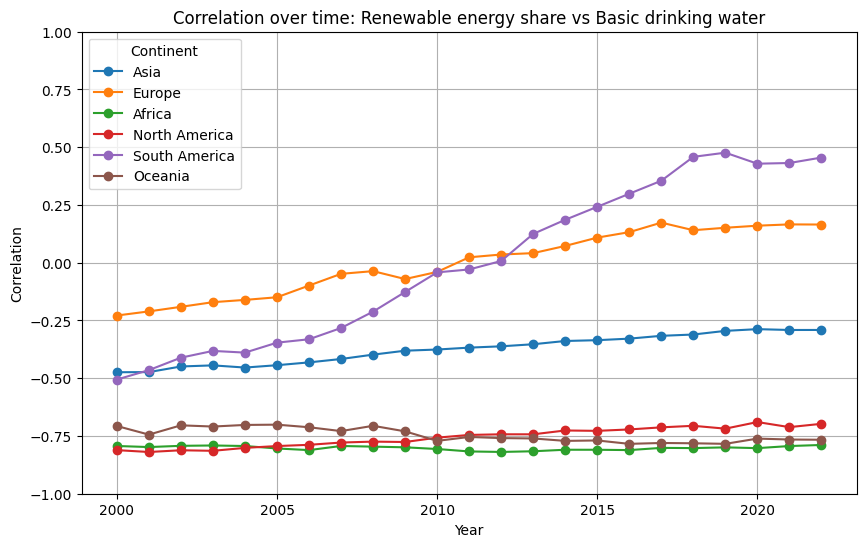

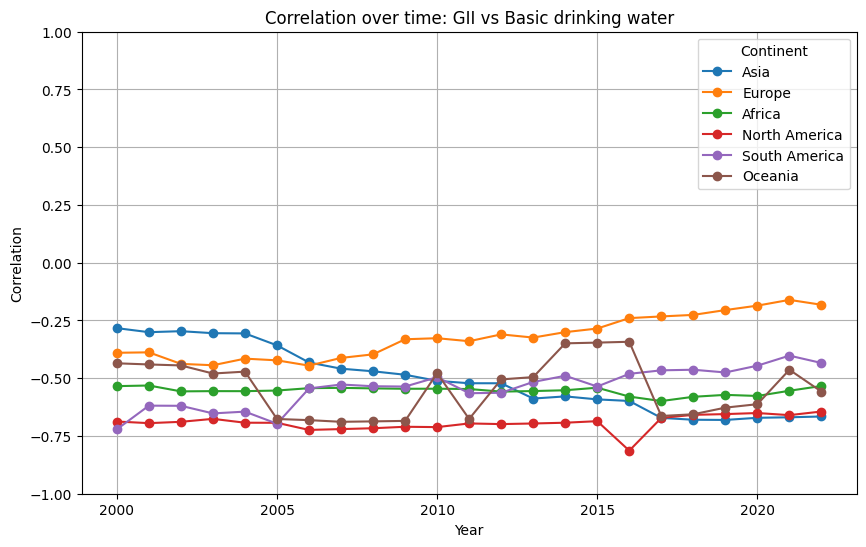

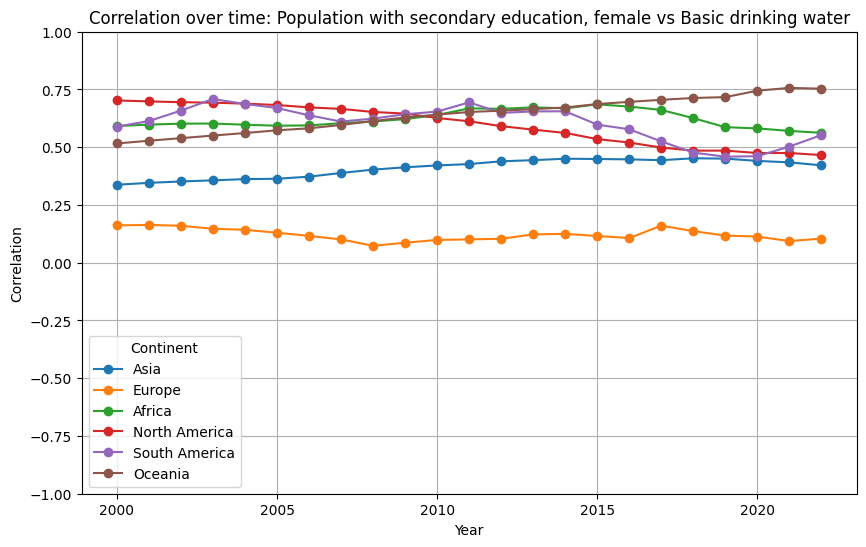

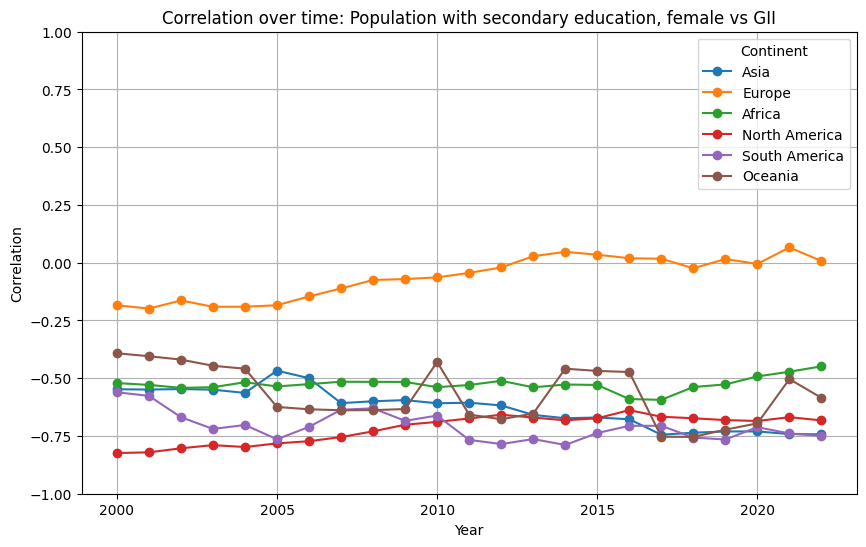

In [30]:
# Define your main correlated pairs
main_pairs = [
    ('Renewable energy share', 'Basic drinking water'),
    ('GII', 'Basic drinking water'),
    ('Population with secondary education, female', 'Basic drinking water'),
    ('Population with secondary education, female', 'GII')
]

continents = data['continent'].unique()
years = sorted(data['year'].unique())

# Loop through each pair
for x_col, y_col in main_pairs:
    # Prepare a DataFrame to store correlations per continent per year
    corr_data = pd.DataFrame(index=years, columns=continents)
    
    for continent in continents:
        for year in years:
            subset = data[(data['continent'] == continent) & (data['year'] == year)]
            if len(subset) >= 2:  # need at least 2 countries to compute correlation
                corr_value = subset[[x_col, y_col]].corr().iloc[0,1]
            else:
                corr_value = None
            corr_data.loc[year, continent] = corr_value
    
    # Plot correlations over time
    plt.figure(figsize=(10,6))
    for continent in continents:
        plt.plot(corr_data.index, corr_data[continent].astype(float), marker='o', label=continent)
    
    plt.title(f'Correlation over time: {x_col} vs {y_col}')
    plt.xlabel('Year')
    plt.ylabel('Correlation')
    plt.ylim(-1, 1)
    plt.grid(True)
    plt.legend(title='Continent')
    plt.show()


TO DO: add explanation

# 4. Machine Learning

We have seen that grouping countries by continents provides some meaningful insights, but is it really the most effective method of comparison?

This question motivated our Machine Learning analysis. To explore it, we use an unsupervised machine learning technique called clustering. This allows us to create country clusters with no asssigned labels. Within the learnt library of scikitlearn we used kmeans. Its algorithm assigns data points to centroids (the center of a cluster) interatively until the clusters are stable and the algorhithm converges.

## 4.1. Oldest VS Latest

First we will do a clustering analysis of gender equality and environmental sustainability overtime, comparing the clusters from the first year in the data set to the ones of the last year. We get the data from the most recent country in the dataset and the least recent one.

In [31]:
oldest_idx = data.groupby('country')['year'].idxmin()
latest_idx = data.groupby('country')['year'].idxmax()

oldest = data.loc[oldest_idx, ['country'] + numeric_cols].set_index('country')
latest = data.loc[latest_idx, ['country'] + numeric_cols].set_index('country')

We will then use the elbow method to get the most optimal number of clusters that we will define in the next step. This method was followed according to https://www.w3schools.com/python/python_ml_k-means.asp.

The elbow method measures a value called inertia for possible numbers of clusters. Inertia  measures the  amount of variation within clusters (with an lower inertia being desirable). The elbow of the diagram is where inertia stops dropping significantly so that the clusters are significant but not too complex.

In [32]:
# Suppressing memory warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")

In [72]:
def elbow_method(df, max_clusters=10, title='Elbow Method'):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    
    inertias = []
    K = range(1, max_clusters + 1)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, algorithm='lloyd')
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(6,4))
    plt.plot(K, inertias, marker='o')
    plt.title(f'{title}: Elbow Method')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

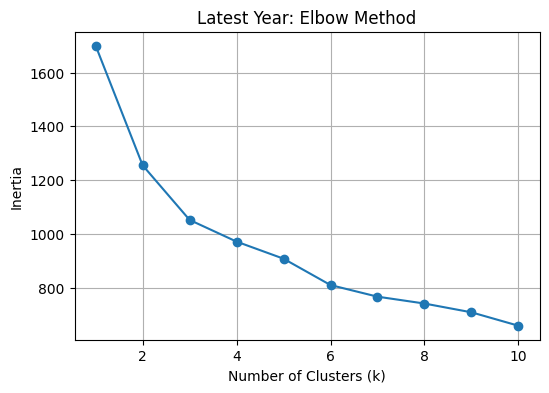

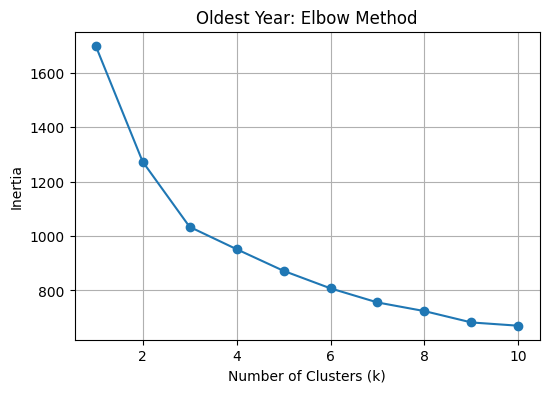

[1700.0,
 1273.6739996589872,
 1033.8589581750928,
 951.7554777385158,
 872.1180893109537,
 807.661847999136,
 755.7760594993237,
 724.0339134478813,
 682.2928076880073,
 670.2432358680607]

In [34]:
elbow_method(latest, title='Latest Year')
elbow_method(oldest, title='Oldest Year')

As the elbow seems to be 3 for both years, we will use it as the same amount of clusters. After, we create a fucntion to find the clusters for each year with kmeans, an unspervised machine learning method. To visualize the clusters, we use Principal Component Analysis (PCA), a method that reduces the dataset’s many variables into just a few new ones called principal components which capture most  variation in the data.

In [71]:
def cluster_and_plot(df, n_clusters=3, title='Clusters'):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    fig = px.scatter(
        plot_df,
        x='PCA1',
        y='PCA2',
        color='Cluster',
        title=title,
        labels={'PCA1': 'PCA 1', 'PCA2': 'PCA 2'},
        hover_data=[df.index],
        color_discrete_sequence=px.colors.qualitative.Set2
    )
    
    return labels

We now show the PCA clusters and store the clusters as lables for the following steps.

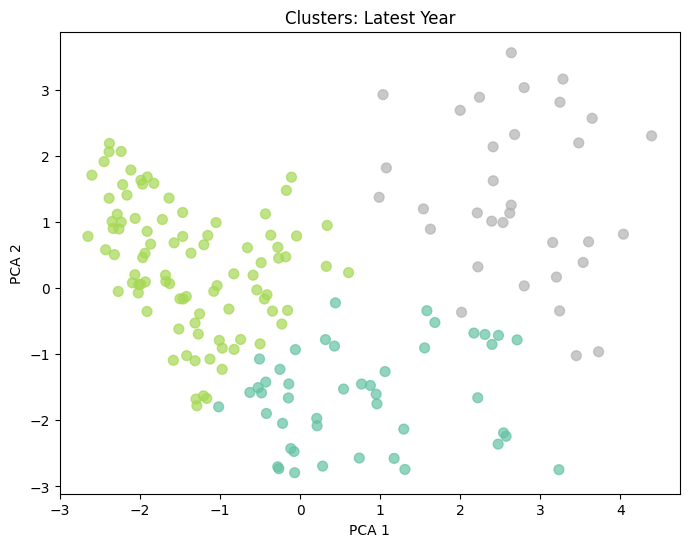

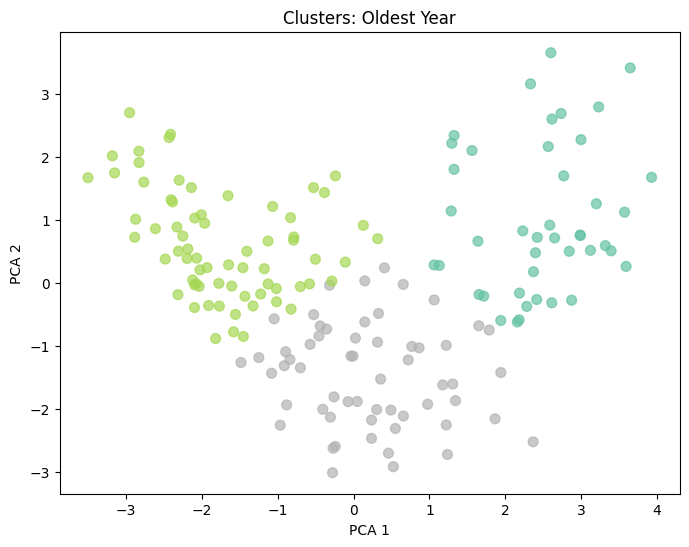

In [37]:
latest_labels = cluster_and_plot(latest, n_clusters=3, title='Clusters: Latest Year')
oldest_labels = cluster_and_plot(oldest, n_clusters=3, title='Clusters: Oldest Year')

And finally we see the coefficients for each cluster of the two years. We can then compare the evolution of th relationship between Environmental sustainability and Gender Equality.

In [38]:
def analyze_clusters(df, labels, dataset_name='Dataset', cluster_map=None):
    df = df.copy()
    df['Cluster'] = labels

    print(f"Cluster Analysis: {dataset_name}")
    print(df.groupby('Cluster').mean().round(2))
    print(df.groupby('Cluster').std().round(2))
    print(df['Cluster'].value_counts())

In [40]:
analyze_clusters(oldest, oldest_labels, dataset_name='Oldest Year')

Cluster Analysis: Oldest Year
         Basic drinking water    GII  Labour force participation, female  \
Cluster                                                                    
0                       55.20  61.95                               60.49   
1                       94.46  27.99                               51.60   
2                       86.75  51.55                               36.01   

         Population with secondary education, female  \
Cluster                                                
0                                              14.84   
1                                              72.42   
2                                              38.37   

         Shares of seats in the parliament, female  Air Polution SO2 trend  \
Cluster                                                                      
0                                            10.22                   42.52   
1                                            16.63                   87.53

- Cluster 0 (n = 43): Low Gender equality, moderate environmental sustainability.
- Cluster 1 (n = 69): High gender equality, poor environmental performance.
- Cluster 2 (n = 58): Medium gender equality, poor environmental sustainability.

In [41]:
analyze_clusters(latest, latest_labels, dataset_name='Latest Year')

Cluster Analysis: Latest Year
         Basic drinking water    GII  Labour force participation, female  \
Cluster                                                                    
0                       90.99  42.35                               36.74   
1                       97.45  19.49                               54.94   
2                       67.23  54.62                               60.20   

         Population with secondary education, female  \
Cluster                                                
0                                              49.72   
1                                              82.88   
2                                              24.45   

         Shares of seats in the parliament, female  Air Polution SO2 trend  \
Cluster                                                                      
0                                            19.02                   53.76   
1                                            29.51                   90.21

- Cluster 0 (n = 46): Medium gender equality, weak environmental sustainability .
- Cluster 1 (n = 91): High gender equality,  mixed environmental sustainability (higher on bioderversity than emissions or energy).
- Cluster 2 (n = 33): Low/medium gender equality, very high environmental sustainability.

Clusters 0 and 2 seem to have switched. More countries join cluster 1, the number of those in initial class 0 and after cluster 2 and viceversa are lower now. All clusters have higher gender equality than before and slightly improve on environmental sustainability.

## 4.2. Trends

 Let's analyse trends deeper with an overall clustering and slope overview:

In [42]:
trend_features = []

for country, group in data.groupby('country'):
    group = group.sort_values('year')
    features = {'country': country}
    
    for col in numeric_cols:
        slope, intercept = np.polyfit(group['year'], group[col], 1)
        features[f'{col}_slope'] = slope
        features[f'{col}_mean'] = group[col].mean()
    
    trend_features.append(features)

df_trends = pd.DataFrame(trend_features)

In [43]:
scaler = StandardScaler()
X_trends = scaler.fit_transform(df_trends.drop(columns='country'))

In [44]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_trends['Cluster'] = kmeans.fit_predict(X_trends)

In [45]:
numeric_cols_trends = df_trends.select_dtypes(include=np.number).columns
cluster_summary = df_trends.groupby('Cluster')[numeric_cols_trends].mean().round(2)
print(cluster_summary)

         Basic drinking water_slope  Basic drinking water_mean  GII_slope  \
Cluster                                                                     
0                              0.87                      63.38      -0.33   
1                              0.03                      98.50      -0.48   
2                              0.29                      91.49      -0.67   

         GII_mean  Labour force participation, female_slope  \
Cluster                                                       
0           57.53                                     -0.34   
1           15.50                                      0.28   
2           41.64                                      0.21   

         Labour force participation, female_mean  \
Cluster                                            
0                                          57.86   
1                                          54.17   
2                                          42.98   

         Population with secondary ed

**TO DO: add tables, explain the trend clustering/maybe try taking the difference of two years**

Results in slope coefficients once again show that while gender equality has generally improved over time, environmental sustainability trends are more mixed. Let's see the countrie of each cluster.

Where cluster 0 encompasses developing countries, cluster 1 mostly shoes Developed Countries and Cluster 2 shoes middle income or emerging countries.

------
# TO DO: add discussion and conclusion

------
# TO DO: add reflection and AI statement
we did amazing